In [1]:
%reset -f

# 0. Import dependencies and load data

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))


In [3]:
from src.model_utility_functions import (
    preprocess_data,
    split_data,
    extract_features
)

from src.lag_utility_functions import (
    plot_acf_pacf,
    evaluate_ar_model,
    compare_lag_sets,
    plot_predictions,
)

from src.ma_utility_functions import (
    evaluate_moving_average,
    compare_moving_average_windows,
    plot_moving_average_predictions
)

In [4]:
DATA_FOLDER_PATH = os.path.join(os.path.dirname(os.getcwd()), "data")
BASE_FILE_NAME = "_in_USD_historical_data.csv"

In [5]:
btc = pd.read_csv(os.path.join(DATA_FOLDER_PATH, f"BTC{BASE_FILE_NAME}"))
btc = preprocess_data(btc)
eth = pd.read_csv(os.path.join(DATA_FOLDER_PATH, f"ETH{BASE_FILE_NAME}"))
eth = preprocess_data(eth)
ltc = pd.read_csv(os.path.join(DATA_FOLDER_PATH, f"LTC{BASE_FILE_NAME}"))
ltc = preprocess_data(ltc)

In [7]:
train, test = split_data(btc, train_ratio=0.8)

# 1.1. Find best lags

In [ ]:
plot_acf_pacf(btc, lags=20)

based on the ACF and PACF results I choose the lags 1, 2, 7

In [7]:
lag_set = (1, 2, 7, 10)

In [ ]:
predictions_dict = {}
for lags in lag_set:
    _, predictions = evaluate_ar_model(train, test, lags)
    predictions_dict[lags] = predictions

# Step 5: Plot the actual and predicted values using the predictions_dict
plot_predictions(test, predictions_dict)

In [ ]:
compare_lag_sets(btc, lag_set)

1.2. Choose  Moving Average windows

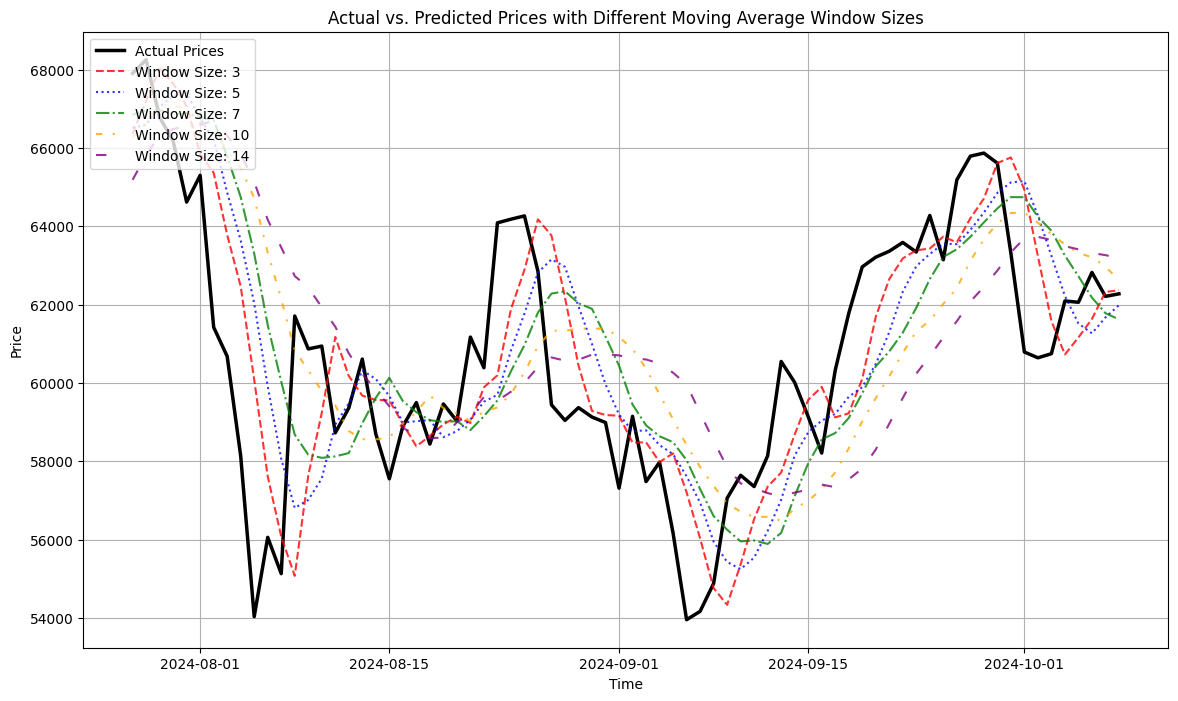

Mean Squared Error for each window size:
Window Size 3: MSE = 4576861.8917
Window Size 5: MSE = 6252397.1875
Window Size 7: MSE = 7631886.2950
Window Size 10: MSE = 9338808.0653
Window Size 14: MSE = 11630820.7254


In [8]:
window_sizes = [3, 5, 7, 10, 14]


mse_results, predictions_dict = compare_moving_average_windows(btc, window_sizes)


plot_moving_average_predictions(test, predictions_dict)


print("Mean Squared Error for each window size:")
for window_size, mse in mse_results.items():
    print(f"Window Size {window_size}: MSE = {mse:.4f}")
